In [1]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase2 import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [2]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,verbose)
        self.mem = {}
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            noChoices = random.randint(1,len(self.domain[key])//10)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        print(f"crossover {population.goal}")
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda summary2,goal: ["
        pos = []
        neg = []
        posMatch = []
        negMatch = []
        notZero = 0
        for gen in chromosome.genes:
            temp2 = []
            temp3 = []
            isZero = True
            for val in gen.value:
                if val != -1:
                    isZero=False
                    temp = f"summary2[{gen.identifier}][{val}][goal] if goal in summary2[{gen.identifier}][{val}] else set()"
                    temp2.append(temp)
                    for goal in self.goals:
                        if goal != -1:
                            temp3.append(f"summary2[{gen.identifier}][{val}][{goal}] if goal != {goal} and {goal} in summary2[{gen.identifier}][{val}] else set()")
            notZero += 1 if not isZero else 0
            pos.append(f"set([]).union(*[{','.join(temp2)}])")
            neg.append(f"set([]).union(*[{','.join(temp3)}])")
        rule += f"[{','.join(pos)}],[{','.join(neg)}],{notZero if notZero > 0 else 100000}"+"]"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        start = time.time()
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        totalPosMatch,totalNegMatch,noChromosomes = matchProportion(self.summarized2,goal)
        countPosMatch = 0
        for row in totalPosMatch:
            for col in row:
                countPosMatch += self.matrix[col][1]
        countPosMatch = countPosMatch / noChromosomes
        countNegMatch = 0
        for row in totalNegMatch:
            for col in row:
                countNegMatch += self.matrix[col][1]
        countNegMatch = countNegMatch / noChromosomes
        totalPos = self.summarized["total"][goal]
        totalNeg = self.summarized["total"]["total"]-self.summarized["total"][goal]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples) 
        negProp = (totalNeg/totalExamples) 
        total = (countPosMatch * negProp) + (-1*countNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        res = total/maxTotal
        print(f"total match elapsed time {goal} {time.time()-start}")
        return res
    
    def regulation(self,population):
        print(f"regulate {population.goal}")
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = [x for x in range(1,len(population.chromosomes))]
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 1
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .5
        self.noChromosomes = 3
        self.noIterations = 10
        super().setup()

In [3]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatchDynamic = 0
        totalMatchStatic = 0
        totalStatic = 0
        totalDynamic = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatchDynamic += (cell0 != cell1 and cell1 == cell2)
            totalMatchStatic += (cell0 == cell1 and cell1 == cell2)
            totalStatic += (cell0 == cell1)
            totalDynamic += (cell0 != cell1)
        totalStatic = totalStatic if totalStatic > 0 else 0
        totalDynamic = totalDynamic if totalDynamic > 0 else 0
        return [totalStatic,totalDynamic,totalMatchStatic,totalMatchDynamic]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: print(summation)
                totalStatic = summation[2]/summation[0] if summation[0] > 0 else 0
                totalDynamic = summation[3]/summation[1] if summation[1] > 0 else 0
                res.append([totalStatic,totalDynamic])
        self.result = np.array(res)
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result[:,0])
        plt.plot(range(len(self.result)),self.result[:,1])
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

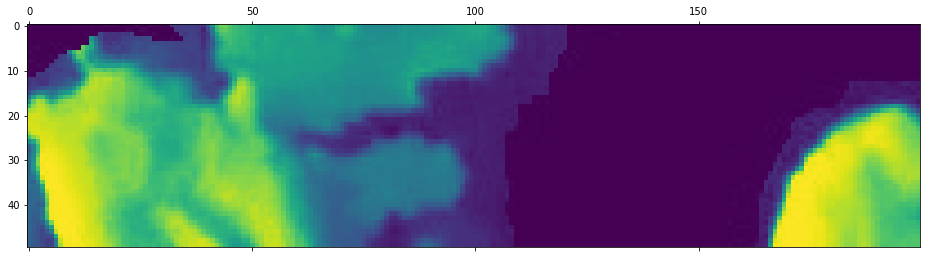

In [16]:
data  = np.load("data/data_gray.npy")
plt.matshow(data[2,50:100,50:250])

In [ ]:
data  = np.load("data/data_gray.npy")
data = data[:,50:100,50:250]
print(np.shape(data))
train = math.floor(len(data) * 0.8)
print(np.shape(data[:train]))
exp2 = Experiment1(data[:train],"Experiment5","mould3_5gray",verbose=2)
exp2.run()

(708, 50, 200)
(566, 50, 200)
start setup
Start 2 (50, 200)Start 3 (50, 200)

Start 1 (50, 200)Start 4 (50, 200)

middle 7.8514838218688965
middle 7.869507074356079
middle 7.874675989151001middle 7.8743672370910645

End 2 8.109853029251099
Start 5 (50, 200)End 1 8.202635049819946End 4 8.208353042602539

Start 6 (50, 200)

Start 7 (50, 200)
End 3 8.234570980072021
Start 8 (50, 200)
middle 6.606616973876953
middle 6.601312160491943middle 6.678963899612427

End 5 6.89528489112854End 8 6.866374969482422End 7 6.887963056564331

Start 9 (50, 200)

Start 10 (50, 200)
Start 11 (50, 200)
middle 7.257861137390137
End 6 7.37332820892334
Start 12 (50, 200)
middle 6.3932411670684814middle 6.402217864990234

End 11 6.751444339752197
End 10 6.7772698402404785Start 13 (50, 200)

Start 14 (50, 200)
middle 6.860046863555908
End 9 6.966629981994629
Start 15 (50, 200)
middle 6.786037921905518
End 12 6.898438930511475
Start 16 (50, 200)
middle 6.94757604598999middle 6.957016229629517

End 13 7.140825271606

In [17]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [19]:
prediction = []
for it in model.run(data[0],50):
    prediction.append(it[1])

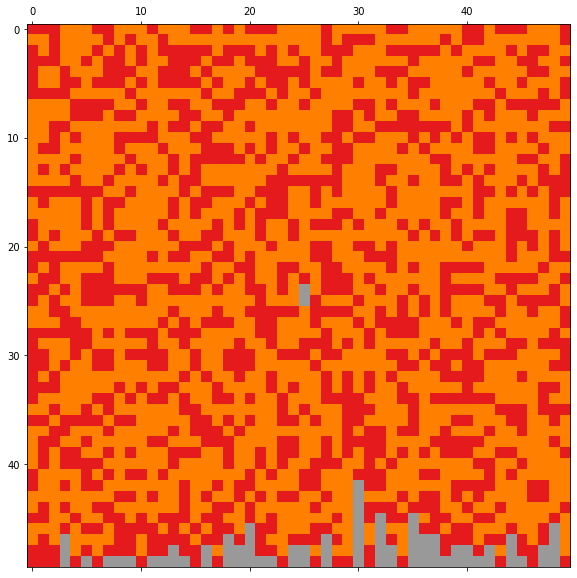

In [20]:
helpers.animate(prediction)

Testing:
state 1/50
[2 4]
state 2/50
[2 7]
state 3/50
[2 9]
state 4/50
[ 3 10]
state 5/50
[2 9]
state 6/50
[3 8]
state 7/50
[2 8]
state 8/50
[0 8]
state 9/50
[0 8]
state 10/50
[2 8]
state 11/50
[ 5 12]
state 12/50
[ 4 17]
state 13/50
[ 5 17]
state 14/50
[ 2 13]
state 15/50
[ 4 11]
state 16/50
[ 5 15]
state 17/50
[ 4 20]
state 18/50
[ 6 21]
state 19/50
[ 7 21]
state 20/50
[ 8 25]
state 21/50
[14 34]
state 22/50
[12 39]
state 23/50
[ 7 34]
state 24/50
[ 7 26]
state 25/50
[ 3 19]
state 26/50
[ 5 16]
state 27/50
[ 2 14]
state 28/50
[ 5 13]
state 29/50
[ 5 17]
state 30/50
[ 9 23]
state 31/50
[12 28]
state 32/50
[11 31]
state 33/50
[10 31]
state 34/50
[ 8 27]
state 35/50
[ 7 25]
state 36/50
[10 29]
state 37/50
[ 7 27]
state 38/50
[ 7 26]
state 39/50
[ 5 27]
state 40/50
[10 30]
state 41/50
[12 40]
state 42/50
[12 41]
state 43/50
[ 9 36]
state 44/50
[ 7 28]
state 45/50
[ 6 20]
state 46/50
[ 7 19]
state 47/50
[ 7 21]
state 48/50
[ 6 22]
state 49/50
[10 25]


<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

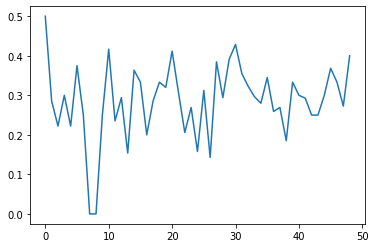

In [77]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

In [13]:
visualization = Visualization("2dfire_exp3/18_12_19_09_50_39")

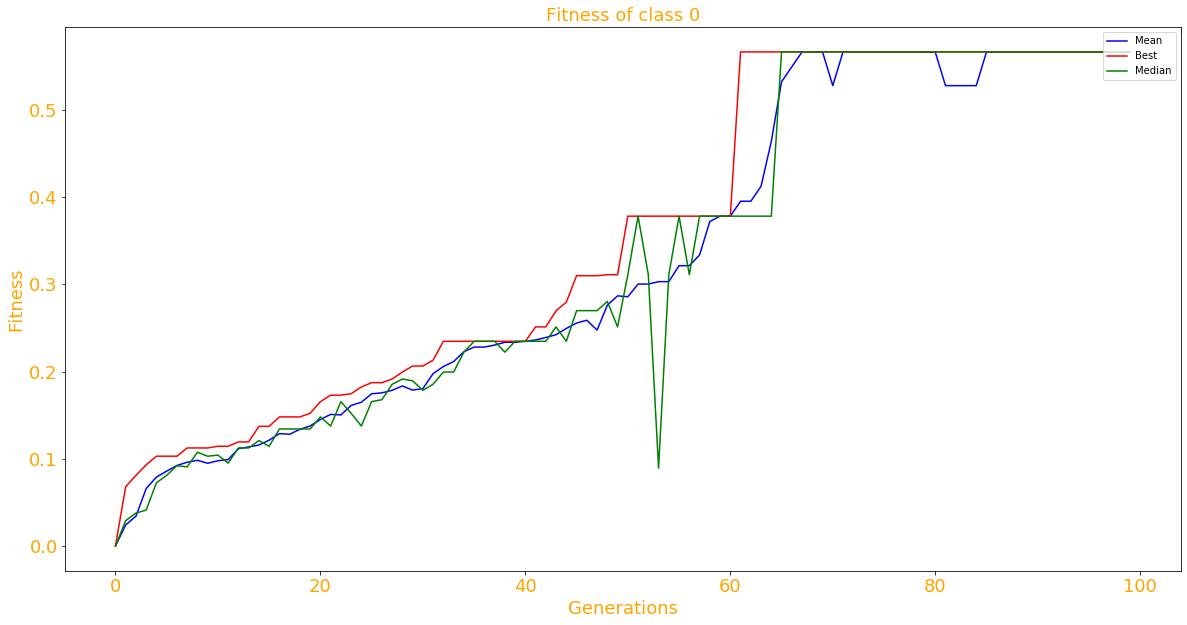

In [14]:
visualization.getFitnessGraph("0")

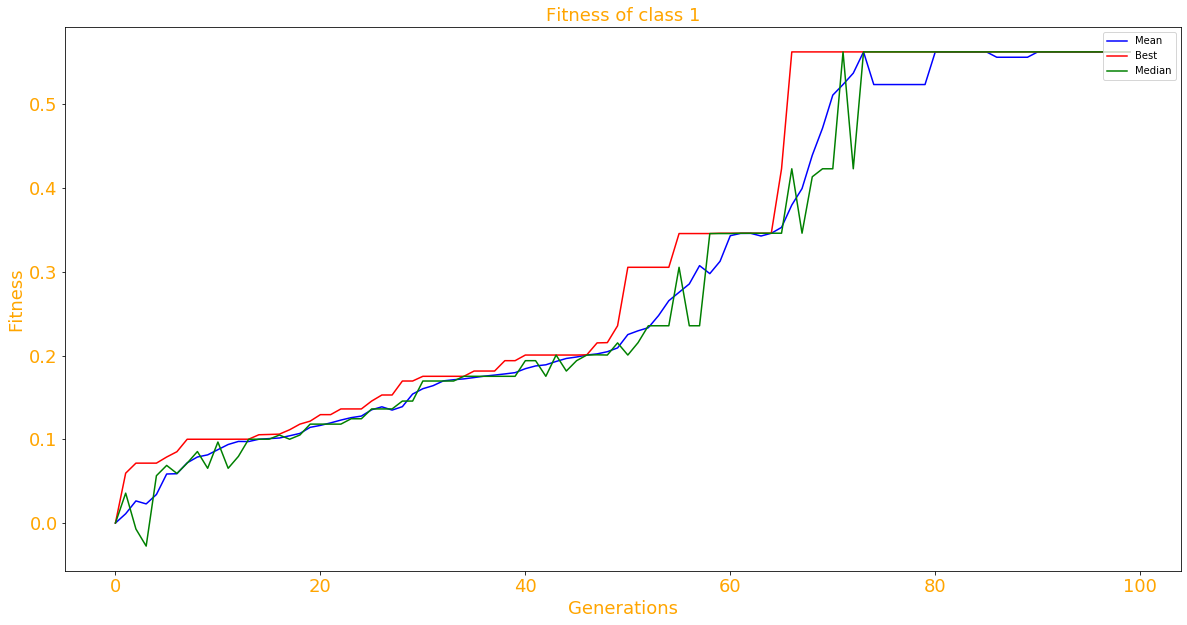

In [15]:
visualization.getFitnessGraph("1")

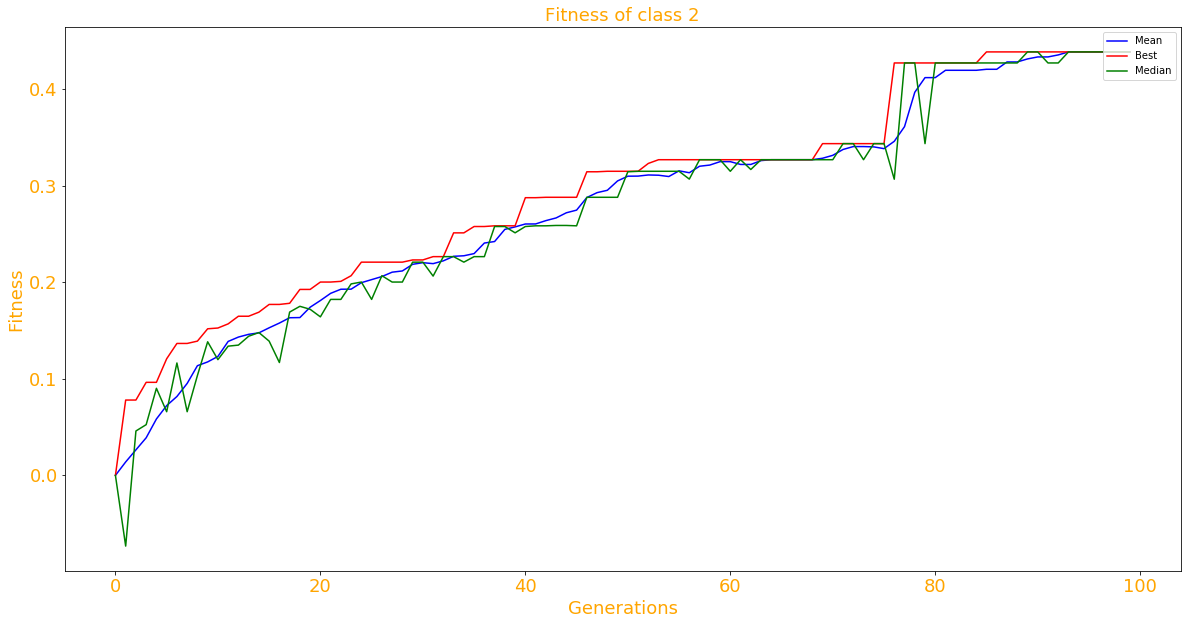

In [16]:
visualization.getFitnessGraph("2")

In [18]:
transformer.lmstr

{0: 'lambda x: (x[12] in {0} if x[12] != -1 else True) and (x[13] in {0, 2} if x[13] != -1 else True)',
 1: 'lambda x: (x[8] in {1, 2} if x[8] != -1 else True) and (x[12] in {1} if x[12] != -1 else True)',
 2: 'lambda x: (x[12] in {1} if x[12] != -1 else True) and (x[17] in {2} if x[17] != -1 else True)'}

In [62]:
exp2.world.toDict()

{'generation': 99,
 'populations': [{'generation': 99,
   'goal': '0',
   'chromosomes': [{'uuid': '69864558-f3a0-41fa-b837-91d64974b952',
     'generation': 95,
     'genes': [{'identifier': '0', 'value': 'set()'},
      {'identifier': '1', 'value': 'set()'},
      {'identifier': '2', 'value': 'set()'},
      {'identifier': '3', 'value': '{-1}'},
      {'identifier': '4', 'value': 'set()'},
      {'identifier': '5', 'value': 'set()'},
      {'identifier': '6', 'value': 'set()'},
      {'identifier': '7', 'value': 'set()'},
      {'identifier': '8', 'value': 'set()'},
      {'identifier': '9', 'value': '{0, 2}'},
      {'identifier': '10', 'value': 'set()'},
      {'identifier': '11', 'value': 'set()'},
      {'identifier': '12', 'value': '{0}'},
      {'identifier': '13', 'value': '{-1}'},
      {'identifier': '14', 'value': 'set()'},
      {'identifier': '15', 'value': 'set()'},
      {'identifier': '16', 'value': '{-1}'},
      {'identifier': '17', 'value': '{-1}'},
      {'identifi

In [57]:
import sys
del sys.modules["ExperimentBase"]